In [1]:
from pydub import AudioSegment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.optimize import curve_fit
import numpy as np


In [2]:
def mp3_to_numpy(mp3_path):
    # Load MP3 file
    audio = AudioSegment.from_mp3(mp3_path)
    
    # Convert to mono if stereo
    if audio.channels > 1:
        audio = audio.set_channels(1)
    
    # Extract raw audio data and sample rate
    samples = np.array(audio.get_array_of_samples())
    sample_rate = audio.frame_rate
    
    # Ensure that the audio data is in the right shape (1D array)
    if len(samples.shape) > 1:
        samples = samples[:, 0]
    
    return samples, sample_rate


In [3]:
# Path to the MP3 file
mp3_path = 'mellow-future-bass-bounce-on-it-184234.mp3'

# Convert MP3 to numpy array and get sample rate
samples, sample_rate = mp3_to_numpy(mp3_path)
samples.shape, sample_rate

((5701248,), 44100)

In [15]:
samples.dtype

dtype('int16')

In [4]:

# Generate spectrogram
# Parameters for spectrogram
nperseg = 800  # Number of samples per segment
noverlap = int(nperseg * 0.8)   # Overlap between segments

# Generate spectrogram
frequencies, times, Sxx = spectrogram(samples, sample_rate, nperseg=nperseg, noverlap=noverlap)
data_rate = times.shape[0] / times[-1]
print("data rate", data_rate)
volume = 10 * np.log10(Sxx)
data_rate

data rate 275.6133962025849


/tmp/ipykernel_16865/778098699.py:10: RuntimeWarning: divide by zero encountered in log10
  volume = 10 * np.log10(Sxx)


np.float64(275.6133962025849)

In [5]:
def estimate_ratio(N, sample_rate, nperseg, noverlap):
    step = nperseg - noverlap
    M = (N - noverlap) // step
    time_step = step / sample_rate
    time_span = (M - 1) * time_step
    if time_span == 0:
        return None  # Prevent division by zero
    ratio = M / time_span
    return ratio
estimate_ratio(samples.shape[0], sample_rate, nperseg=nperseg, noverlap=noverlap)

275.6327364077806

In [6]:
freq_mask = frequencies < 300
frequencies = frequencies[freq_mask]
volume = volume[freq_mask]
print(times.shape, np.min(times), np.max(times))
print(frequencies.shape, np.min(frequencies), np.max(frequencies))
print(volume.shape, np.min(volume), np.max(volume))


(35628,) 0.009070294784580499 129.26802721088436
(6,) 0.0 275.625
(6, 35628) -inf 69.45646


In [7]:
mean_window_length = 0.1
y = np.sum(volume, axis=0) / volume.shape[0]
smoothed_data = pd.Series(y).rolling(
    window=int(mean_window_length * data_rate), center=True, min_periods=0
    ).mean()

In [8]:
start_sec = 33
end_sec = 48
end = 129
start_index = int(smoothed_data.shape[0] * start_sec / end)
end_index = int(smoothed_data.shape[0] * end_sec / end)
sample_interval = smoothed_data[start_index:end_index]
time_interval = times[start_index:end_index]
volume_interval = volume[:,start_index:end_index]

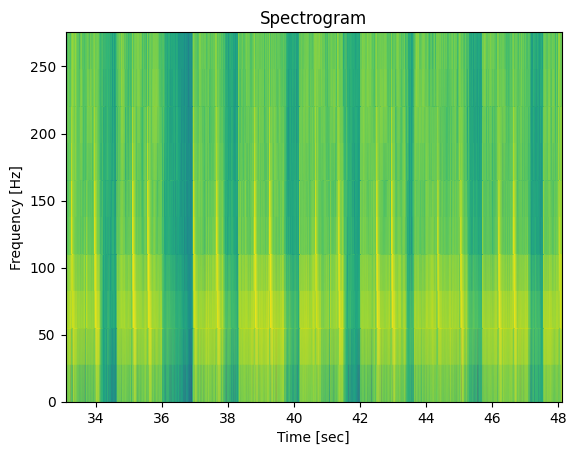

In [9]:
plt.pcolormesh(time_interval, frequencies, volume_interval, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.show()

Text(0, 0.5, 'Bassiness™')

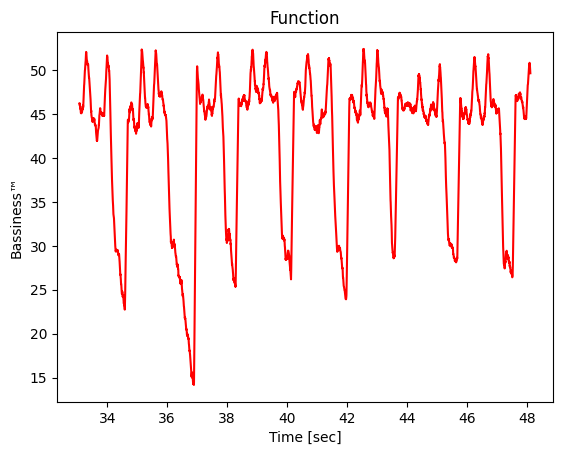

In [10]:

grad = np.gradient(sample_interval)
nor_grad = (grad * np.max(time_interval) / np.max(grad))
nor_grad = pd.Series(nor_grad).rolling(20).mean()
plt.plot(time_interval, sample_interval, 'r')
#plt.plot(time_interval, nor_grad + 45, 'b')
plt.title('Function')
plt.xlabel('Time [sec]')
plt.ylabel('Bassiness™')

In [14]:
chunk_length = 0.05
chunk_size = int(data_rate * chunk_length)
nr_chunks = sample_interval.shape[0] // chunk_size
chunks =np.array( np.split(np.array(sample_interval)[:nr_chunks*chunk_size], nr_chunks))
print(chunks.shape, chunk_size)

(318, 13) 13


In [12]:
lookback_window_length = 1
lookback_window_size = int(lookback_window_length * data_rate)

lookback_window = chunks[0].copy()
y = []
for c in chunks[1:]:
    m = c.mean()
    prob = (lookback_window < m).mean()
    y.append(prob)
    lookback_window = np.concat((lookback_window, c))[-lookback_window_size:]



[np.float64(0.0), np.float64(0.7692307692307693), np.float64(1.0), np.float64(1.0), np.float64(0.8769230769230769), np.float64(0.6282051282051282), np.float64(0.45054945054945056), np.float64(0.0), np.float64(0.0), np.float64(0.03076923076923077), np.float64(0.0), np.float64(0.0), np.float64(0.10650887573964497), np.float64(0.45054945054945056), np.float64(0.39487179487179486), np.float64(0.36538461538461536), np.float64(0.5294117647058824), np.float64(0.7777777777777778), np.float64(0.9392712550607287), np.float64(0.8576923076923076), np.float64(0.6593406593406593), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.014545454545454545), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.13454545454545455), np.float64(0.4618181818181818), np.float64(0.6145454545454545), np.float64(0.7781818181818182), np.float64(0.8145454545454546), np.float64(0.7563636363636363), np.float64(0.5781818181818181), np.float64(0.5

(40.0, 48.85097505668934)

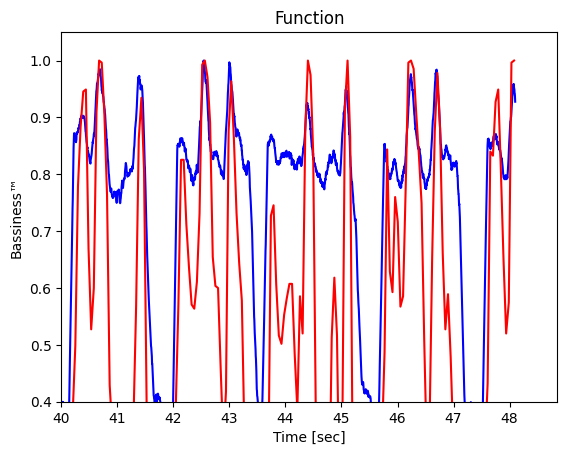

In [13]:
print(y)

si_norm = (sample_interval - np.min(sample_interval)) / (np.max(sample_interval) - np.min(sample_interval))
plt.plot(time_interval, si_norm, 'b')
plt.plot(time_interval[::chunk_size][:len(y)]+0.1, y, 'r')
plt.title('Function')
plt.xlabel('Time [sec]')
plt.ylabel('Bassiness™')
plt.ylim(0.4)
plt.xlim(40)